In [339]:
import os
import glob

import pandas as pd



# from sklearn.linear_model import Lasso, LassoCV, LogisticRegressionCV, LogisticRegression
# from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import r2_score, explained_variance_score, normalized_mutual_info_score, mutual_info_score
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.dummy import DummyRegressor
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
# from sklearn.ensemble import IsolationForest

from keras.losses import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as K
from keras import regularizers
from keras import optimizers
# from keras.layers import Lambda

from hyperopt import Trials, fmin, tpe, hp, STATUS_OK

from mlxtend.plotting import plot_learning_curves
from mlxtend.data import iris_data
from mlxtend.preprocessing import shuffle_arrays_unison

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle as pkl
import datetime

import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 8, 8

Custom model implementations and functions are stored in `src/dairyml.py`

In [2]:
from dairyml import PerfectClassifierMeanRegressor, plot_r2, BoundedLasso, BoundedLassoPlusLogReg, plot_coefficients

## Import the Data
Load the data from the csv file, and set FoodCode to be the data index

In [3]:
data = pd.read_csv('../data/training_for_GS_122118.csv')
data = data.set_index('FoodCode')

Get the indices of all columns except description and lactose content - these columns are the numerical features that will be used as model input



In [4]:
numerical_features = data.columns[1:-1]
# print(numerical_features)

## Prepare data for modelling
### Standardize the input features
- Use only the numerical features as model input `X`  
- Use sklearn's `StandardScaler` on these features: this standardizes features by removing the mean and scaling to unit variance 
- Convert the output of `StandardScaler` back to a dataframe for convenience

In [134]:
ss = StandardScaler()
X = pd.DataFrame(ss.fit_transform(data[numerical_features]),columns=data[numerical_features].columns)
# X.head()

### Use lactose as prediction target `Y`

In [135]:
Y = data['lac.per.100g']
# Y.head()

## Modelling

We will use the below splitter for cross-validation: 10 folds, with shuffling

In [292]:
splitter= KFold(n_splits=5,shuffle=True,random_state=7)

### Baseline Models


#### Mean

In [293]:
# dummy_mean = DummyRegressor(strategy='mean')
# dummy_mean_score = np.round(np.mean(cross_val_score(dummy_mean,X,Y,cv=splitter,scoring='r2')),2)

# print('Dummy model (Mean) testing R^2: {}'.format(dummy_mean_score))

#### Median

In [294]:
# dummy_mean = DummyRegressor(strategy='median')
# dummy_mean_score = np.round(np.mean(cross_val_score(dummy_mean,X,Y,cv=splitter,scoring='r2')),2)

# print('Dummy model (Median) testing R^2: {}'.format(dummy_mean_score))

#### Perfect classifier plus mean regressor
- This classifier predicts 0 where the true value is 0, or the mean of the training lactose values where the true value is nonzero

- See dairyml.py for implementation

(This class is not compliant with sklearn conventions, this was the easiest implementation I could think of to include perfect classification)

In [295]:
# pcmr = PerfectClassifierMeanRegressor()
# pcmr.fit(X,Y)
# dummy_pcmr_score = np.round(np.mean(pcmr.cross_val()),2)

# print('Dummy model (Perfect Classification, Mean Regression) testing R^2: {}'.format(dummy_pcmr_score))

# Feed-Forward Neural Network (FFNN)

### Function to build model

In [296]:
# custom R2-score metrics for keras backend
# https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/discussion/34019
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [297]:
def create_model(hidden_layers,num_nodes,alpha=0.01,lr=.001): 
    
    reg = regularizers.l2(alpha)
    
    model = Sequential()
    
    model.add(Dense(num_nodes, input_dim=X.shape[1], activation='relu', kernel_regularizer = reg))
    
    for i in range(0,hidden_layers-1):
        model.add(Dense(num_nodes, activation='relu', kernel_regularizer = reg))
        
    model.add(Dense(1, activation='linear'))
    
    adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
    #add r2 and other metrics
    model.compile(loss='mean_squared_error', optimizer=adam,metrics=['mean_absolute_error',r2_keras])
    return model

### Score CV by r2

In [298]:
scoring = {'r2':make_scorer(r2_score)}

### Plot learning curves for train test split to estimate appropriate number of epochs

In [299]:
# model = create_model(1,60)

# # X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=7, shuffle=True)
# # plot_learning_curves(X_train, y_train, X_test, y_test, model, scoring='r2')

# X_shuf, Y_shuf = shuffle(X,Y,random_state=7)


# history = model.fit(X_shuf, Y_shuf, validation_split=0.2, epochs=200, batch_size=10, verbose=0)
# # list all data in history
# print(history.history.keys())


# plt.plot(history.history['r2_keras'])
# plt.plot(history.history['val_r2_keras'])
# plt.title('R2')
# plt.ylabel('R2')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.ylim(0,1)
# plt.show()

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

### Define objective function (1-r2) for hyperopt

In [309]:
EPOCHS = 100

def objective(params):
# def objective(hidden_layers,num_nodes):
    hidden_layers = int(params['hidden_layers'])
    num_nodes = int(params['num_nodes'])
    alpha = params['alpha']
    lr = params['lr']
    
    print('hidden_layers: {}'.format(hidden_layers))
    print('num_nodes: {}'.format(num_nodes))
    print('alpha: {}'.format(alpha))
    print('lr: {}'.format(lr))
    
    model = KerasRegressor(build_fn=create_model,
                           hidden_layers=hidden_layers,
                           num_nodes=num_nodes,
                           alpha=alpha,
                           lr=lr,
                           epochs=EPOCHS, 
                           batch_size=5, 
                           verbose=0)
    
    results = cross_validate(model,X,Y,cv=splitter,scoring=scoring)
    
    r2 = np.mean(results['test_r2'])
    loss = 1 - r2
    
    print('R^2: {}'.format(r2))
    print('\n')
    
    
    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

min, max, stepsize

### Define the parameter space

In [310]:
space = {
            'hidden_layers': hp.quniform('hidden_layers', 1, 2, 1),
            'num_nodes': hp.qloguniform('num_nodes', np.log(3), np.log(100), 1),
            'lr': hp.loguniform('lr', np.log(1e-4), np.log(1e-2)),
            'alpha': hp.loguniform('alpha', np.log(1e-4), np.log(1e-1))
        }

### Trials object to store results

In [311]:
trials = Trials()

### Run hyperopt

In [312]:
MAX_EVALS = 20

# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = trials)

hidden_layers: 1
num_nodes: 3
alpha: 0.011919348950814248
lr: 0.008696534757119328
R^2: 0.5416689502982143


hidden_layers: 2
num_nodes: 3
alpha: 0.00020897271956071595
lr: 0.0008356388496771893
R^2: 0.6244959023328084


hidden_layers: 1
num_nodes: 40
alpha: 0.014550696296277088
lr: 0.0013488799122571282
R^2: 0.6273493122402498


hidden_layers: 2
num_nodes: 15
alpha: 0.00016259008566805636
lr: 0.00303136585715929
R^2: 0.670933823242754


hidden_layers: 1
num_nodes: 14
alpha: 0.08507975722250913
lr: 0.0003230701818184669
R^2: 0.5537815767459113


hidden_layers: 2
num_nodes: 11
alpha: 0.0038428763695687565
lr: 0.0002261146652768974
R^2: 0.6666974220239805


hidden_layers: 2
num_nodes: 69
alpha: 0.001217427134968658
lr: 0.0006437673256730367
R^2: 0.6891895200319381


hidden_layers: 1
num_nodes: 17
alpha: 0.027634252171355827
lr: 0.009623762199187966
R^2: 0.6086432254029224


hidden_layers: 2
num_nodes: 45
alpha: 0.04684415929397044
lr: 0.002343926589674816
R^2: 0.658396081868497


hidden_

In [441]:
def save_params(params):
    save_string = 'FFNN_best_params-' + str(datetime.datetime.now().strftime("%Y-%m-%d %H-%M %p"))
    params_dir = "../pkl/params/FFNN/"
    
    try:
        os.makedirs(params_dir)
    except FileExistsError:
        pass
    
    with open(params_dir + save_string, "wb" ) as f:
        f.seek(0)
        pkl.dump(params,f)

def load_params():
    params_dir = "../pkl/params/FFNN/*"
    list_of_files = glob.glob(params_dir)
    latest_file = max(list_of_files, key=os.path.getctime)
    print('loading {}'.format(latest_file))
    
    with open(latest_file, "rb") as f:
        f.seek(0)
        params = pkl.load(f)
        
    return params

In [442]:
def save_trials(trials):
    save_string = 'FFNN_trials-' + str(datetime.datetime.now().strftime("%Y-%m-%d %H-%M %p"))
    trials_dir = '../pkl/trials/FFNN/'
    
    try:
        os.makedirs(trials_dir)
    except FileExistsError:
        pass
    
    with open(trials_dir + save_string, "wb" ) as f:
        f.seek(0)
        pkl.dump(trials,f)
        
    print('saved to {}'.format(trials_dir + save_string))

def load_trials():
    trials_dir = "../pkl/trials/FFNN/*"
    list_of_files = glob.glob(trials_dir)
    latest_file = max(list_of_files, key=os.path.getctime)
    print('loading {}'.format(latest_file))
    
    with open(latest_file, "rb") as f:
        f.seek(0)
        trials = pkl.load(f)
        
    return trials

In [444]:
save_params(best)
load_params()

loading ../pkl/params/FFNN\FFNN_best_params-2019-01-21 12-43 PM


{'alpha': 0.005660851233300683,
 'hidden_layers': 1.0,
 'lr': 0.001994170783323986,
 'num_nodes': 59.0}

In [445]:
save_trials(trials)
load_trials()

saved to ../pkl/trials/FFNN/FFNN_trials-2019-01-21 12-44 PM
loading ../pkl/trials/FFNN\FFNN_trials-2019-01-21 12-44 PM


#### Feature importances
Here we plot the non-zero coefficients of the Bounded Lasso model. The magnitude of the coefficient for each feature indicates how much each feature contributes to the overall lactose estimate. We can see that choline, sugar, and potassium contribute positively to the lactose estimate, while fiber, cholesterol, and protein contribute negatively. 

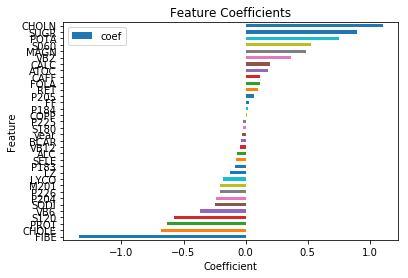

In [22]:
plot_coefficients(search.best_estimator_,X)

### Bounded Lasso plus Classifier
- Add a binary classifier to the model to predict whether a food is zero or non-zero lactose. 
- In the case that the classifier predicts 0 lactose, the overall model output is 0. 
- In the case that the classifier predicts non-zero, the output from the bounded lasso model is used

#### Evaluate the classifier by itself

In [23]:
Y_binary = Y != 0

param_grid_LR = {'C': np.logspace(-4, 4, 30)}

search_LR = GridSearchCV(estimator=LogisticRegression(solver='lbfgs',max_iter=2000),param_grid=param_grid_LR,scoring=('accuracy','recall'),refit='accuracy',cv=10)
search_LR.fit(X,Y_binary)

# param_grid_SVC = {'C': np.logspace(-4, 4, 30)}
# search_SVC = GridSearchCV(estimator=SVC(kernel='rbf'),param_grid=param_grid_SVC,scoring=('accuracy','recall'),refit='accuracy',cv=10)
# search_SVC.fit(X,Y_binary)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=2000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.00000e-04, 1.88739e-04, 3.56225e-04, 6.72336e-04, 1.26896e-03,
       2.39503e-03, 4.52035e-03, 8.53168e-03, 1.61026e-02, 3.03920e-02,
       5.73615e-02, 1.08264e-01, 2.04336e-01, 3.85662e-01, 7.27895e-01,
       1.37382e+00, 2.59294e+00, 4.89390e+00, 9.23671e+00, 1.74333e+01,
       3.29034e+01, 6.21017e+01, 1.17210e+02, 2.21222e+02, 4.17532e+02,
       7.88046e+02, 1.48735e+03, 2.80722e+03, 5.29832e+03, 1.00000e+04])},
       pre_dispatch='2*n_jobs', refit='accuracy',
       return_train_score='warn', scoring=('accuracy', 'recall'),
       verbose=0)

#### Classifier accuracy
The classifier achieves 89% accuracy in predicting 0 vs non-zero lactose.

In [24]:
search_LR.best_score_

0.8941798941798942

### Evaluate the Bounded Lasso + Classifier Model

In [28]:
param_grid = {'alpha': np.logspace(-3, -1, 10), 'C': np.logspace(-4, 4, 10)}
refit='r2'
search = GridSearchCV(estimator=BoundedLassoPlusLogReg(),param_grid=param_grid,scoring=('neg_mean_squared_error','r2'),refit=refit,cv=splitter)
search.fit(X,Y)

GridSearchCV(cv=KFold(n_splits=10, random_state=7, shuffle=True),
       error_score='raise-deprecating',
       estimator=BoundedLassoPlusLogReg(C=None, alpha=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([0.001  , 0.00167, 0.00278, 0.00464, 0.00774, 0.01292, 0.02154,
       0.03594, 0.05995, 0.1    ]), 'C': array([1.00000e-04, 7.74264e-04, 5.99484e-03, 4.64159e-02, 3.59381e-01,
       2.78256e+00, 2.15443e+01, 1.66810e+02, 1.29155e+03, 1.00000e+04])},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score='warn',
       scoring=('neg_mean_squared_error', 'r2'), verbose=0)

In [29]:
search.best_estimator_.get_params()

{'C': 1291.5496650148827, 'alpha': 0.05994842503189409}

#### Model test performance
Highest R^2 score for the Lasso model from 10-fold CV (this is the performance we can expect on the test set)

Performance isn't significantly improved over the model without classifier.

In [30]:
search.best_score_

0.5320283631046228